In [2]:
import os
import sys
import time
import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm.notebook as tq
from collections import defaultdict
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel#, AdamW
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from nltk.corpus import wordnet
from deep_translator import GoogleTranslator
from googletrans import Translator

from tqdm import tqdm
import nltk

#nltk.download('wordnet')
#nltk.download('omw-1.4')
writer = SummaryWriter(log_dir='logs')
translator = Translator()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

AttributeError: module 'httpcore' has no attribute 'SyncHTTPTransport'

In [2]:
MAX_LEN = 100
BATCH = 32
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' #"roberta-base" #'bert-base-cased'
EPOCHS = 10
LEARNING_RATE = 0.00001 # dla MEISD
LEARNING_RATE_FINE = 5e-6    # dla fine-tuningu na ESConv
THRESHOLD = 0.2 #prog decyzyjny
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 0.001
LSTM_LAYERS = 2
LSTM_HIDDEN_DIM = 128
FOCAL_LOSS_ALFA = 4
FOCAL_LOSS_GAMMA = 2
MODE='min'
PATIENCE=2
FACTOR=0.5
VERBOSE=True
output_dir = './fine_tuned_bert_lstm_model'
os.makedirs(output_dir, exist_ok=True)

In [3]:
df_data = pd.read_csv('C:/Users/juwieczo/DataspellProjects/meisd_project/data/filtered_negative_MEISD_intensity_max_first_25_conv.csv')
#df_data = pd.read_csv('C:/Users/juwieczo/DataspellProjects/meisd_project/pipeline/balanced_augmented_data_primary_intensity.csv')

In [4]:
df_data.head()

,dialog_ids,Utterances,max_intensity
0,1,like i said,1
1,2,"now you think i'm gay. no, i'm not gay",1
2,3,now i have to like it here,2
3,4,yes no other reason? just a favor for an old p...,2
4,5,if he doesn't respond to these tests in the ne...,2


In [5]:
label_frequencies = df_data['max_intensity'].value_counts()
label_frequencies_percent = df_data['max_intensity'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

max_intensity
2    49.677419
1    29.032258
3    21.290323
Name: proportion, dtype: float64
max_intensity
2    539
1    315
3    231
Name: count, dtype: int64


In [6]:
df_data['label'] = (df_data['max_intensity'] == 2).astype(int)
#df_data['label'] = (df_data['label'] == 2).astype(int)

columns = ['Utterances', 'label']
df = df_data[columns].copy()

In [7]:
# 1. Synonym Replacement
def synonym_replacement(text):
    words = text.split()
    new_words = words[:]
    num_replacements = max(1, len(words) // 5)  # Replace about 20% of words
    random_words = random.sample(words, num_replacements)

    for word in random_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            #synonym = synonyms[0].lemmas()[0].name()  # Take first synonym
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != word:  # Avoid replacement if the synonym is identical
                new_words = [synonym if w == word else w for w in new_words]
    return ' '.join(new_words)


# 2. Random Insertion
def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        new_word = random.choice(words)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, new_word)
    return ' '.join(words)


# 3. Random Deletion
def random_deletion(text, p=0.3):
    words = text.split()
    if len(words) == 1:
        return text  # Avoid deleting single-word text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if not new_words:
        return random.choice(words)  # Return one word if all words are deleted
    return ' '.join(new_words)

# 4. Back Translation
def back_translation(text, src_lang='en', mid_lang='fr', max_retries=3):
    attempt = 0
    while attempt < max_retries:
        try:
            translated = GoogleTranslator(source=src_lang, target=mid_lang).translate(text)
            back_translated = GoogleTranslator(source=mid_lang, target=src_lang).translate(translated)
            return back_translated
        except Exception as e:
            print(f"Back translation error on attempt {attempt + 1}: {e}")
            attempt += 1
            time.sleep(1)
    raise ValueError("Back translation failed")

In [ ]:
from llama_cpp import Llama

llm = Llama(model_path="C:/Users/juwieczo/DataspellProjects/meisd_project/chatbot/llama-2-7b-chat.Q4_K_M.gguf", n_ctx=2048, n_threads=6, verbose=True)

def generate_esconv_style_response(original_text, examples):
    prompt = f"""
You are an emotional support assistant. Below are example supportive messages from real conversations:
{examples}

Now, rewrite the following message in a similar supportive tone:
"{original_text}"

Response:"""

    output = llm(prompt, max_tokens=150, temperature=0.8, stop=["User:", "Assistant:"])
    return output["choices"][0]["text"].strip()

In [ ]:
import json
import random

def extract_seeker_utterances(json_path, max_dialogs=20, max_examples=5):
    with open(json_path, 'r') as f:
        data = json.load(f)

    seeker_lines = []
    for convo in data[:max_dialogs]:  # ogranicz dla szybkości
        for turn in convo.get("dialog", []):
            if turn.get("speaker") == "seeker":
                content = turn.get("content", "").strip()
                if 20 < len(content) < 150:  # odfiltrowanie krótkich i bardzo długich
                    seeker_lines.append(content)

    random.shuffle(seeker_lines)
    selected = seeker_lines[:max_examples]
    formatted = "\n".join([f"- {line}" for line in selected])
    return formatted


In [ ]:
style_examples = extract_seeker_utterances("ESConv.json")
print(style_examples)

In [ ]:
text = "Nobody listens to me, I feel completely ignored."
print(generate_esconv_style_response(text, style_examples))

In [8]:
def augment_text(text, num_augments=2):
    augmented_texts = []
    for _ in range(num_augments):
        augmentation_choice = random.choice(['synonym', 'insertion', 'deletion', 'back_translation'])
        if augmentation_choice == 'synonym':
            augmented_texts.append(synonym_replacement(text))
        elif augmentation_choice == 'insertion':
            augmented_texts.append(random_insertion(text))
        elif augmentation_choice == 'deletion':
            augmented_texts.append(random_deletion(text))
        elif augmentation_choice == 'back_translation':
            augmented_texts.append(back_translation(text))
    return augmented_texts

In [9]:
from tqdm import tqdm
import pandas as pd

def augment_binary_data(df, label_column, augment_text, num_augments=2):
    """
    Augments binary classification data to balance class distributions.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterances' column and a binary label column.
    - label_column (str): Column name of the binary target label (0 or 1).
    - augment_text (callable): Function to augment text. Should take a string and return a list of augmented strings.
    - num_augments (int): Number of augmented samples to generate per original sample.

    Returns:
    - pd.DataFrame: Augmented DataFrame with balanced class distribution.
    """
    # Oblicz liczność klas
    class_counts = df[label_column].value_counts()
    min_class, max_class = class_counts.idxmin(), class_counts.idxmax()
    num_min, num_max = class_counts[min_class], class_counts[max_class]

    print(f"Liczność klas przed augmentacją: {class_counts.to_dict()}")

    # Pobierz próbki z mniejszej klasy
    class_subset = df[df[label_column] == min_class].copy()

    # Oblicz ile dodatkowych próbek potrzebujemy
    num_to_add = num_max - num_min

    # Inicjalizacja nowego zbioru danych
    augmented_data = {'Utterances': [], label_column: []}

    # Augmentuj dane, ale tylko do momentu wyrównania liczby próbek
    augment_per_sample = max(1, num_to_add // len(class_subset))  # Ile augmentacji na 1 próbkę
    remaining = num_to_add  # Ile jeszcze próbek musimy dodać

    for _, row in tqdm(class_subset.iterrows(), total=len(class_subset), desc=f"Augmenting class {min_class}"):
        if remaining <= 0:
            break

        # Wykonaj augmentację tekstu
        new_texts = augment_text(row['Utterances'], num_augments=min(augment_per_sample, remaining))

        for new_text in new_texts:
            if remaining <= 0:
                break
            augmented_data['Utterances'].append(new_text)
            augmented_data[label_column].append(min_class)
            remaining -= 1  # Zmniejsz licznik brakujących próbek

    # Tworzenie DataFrame z nowymi próbkami
    augmented_df = pd.DataFrame(augmented_data)

    # Połączenie oryginalnych danych z nowymi danymi
    final_df = pd.concat([df, augmented_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

    # Sprawdź finalny rozkład klas
    final_counts = final_df[label_column].value_counts()
    print(f"Liczność klas po augmentacji: {final_counts.to_dict()}")

    return final_df


In [10]:
from tqdm import tqdm
import pandas as pd

def augment_binary_data_percent(df, label_column, augment_text, augment_percent=25):
    """
    Augments binary classification data by a specified percentage.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterances' column and a binary label column.
    - label_column (str): Column name of the binary target label (0 or 1).
    - augment_text (callable): Function to augment text. Should take a string and return a list of augmented strings.
    - augment_percent (int): Percentage increase for each class (e.g., 25 means adding 25% more samples per class).

    Returns:
    - pd.DataFrame: Augmented DataFrame with increased class distributions.
    """
    # Oblicz liczność klas
    class_counts = df[label_column].value_counts()
    print(f"Liczność klas przed augmentacją: {class_counts.to_dict()}")

    # Inicjalizacja nowego zbioru danych
    augmented_data = {'Utterances': [], label_column: []}

    for label in class_counts.index:
        class_subset = df[df[label_column] == label].copy()
        num_to_add = int(class_counts[label] * (augment_percent / 100))

        augment_per_sample = max(1, num_to_add // len(class_subset))
        remaining = num_to_add

        for _, row in tqdm(class_subset.iterrows(), total=len(class_subset), desc=f"Augmenting class {label}"):
            if remaining <= 0:
                break

            new_texts = augment_text(row['Utterances'], num_augments=min(augment_per_sample, remaining))

            for new_text in new_texts:
                if remaining <= 0:
                    break
                augmented_data['Utterances'].append(new_text)
                augmented_data[label_column].append(label)
                remaining -= 1

    # Tworzenie DataFrame z nowymi próbkami
    augmented_df = pd.DataFrame(augmented_data)

    # Połączenie oryginalnych danych z nowymi danymi
    final_df = pd.concat([df, augmented_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

    # Sprawdź finalny rozkład klas
    final_counts = final_df[label_column].value_counts()
    print(f"Liczność klas po augmentacji: {final_counts.to_dict()}")

    return final_df


In [ ]:
def augment_text(text, num_augments=2, use_llm_local=False):
    augmented_texts = []
    for _ in range(num_augments):
        if use_llm_local and random.random() < 0.5:
            augmented_texts.append(generate_esconv_style_response(text, style_examples))
        else:
            # ... klasyczne augmentacje
            augmented_texts.append(random_deletion(text))
    return augmented_texts

In [11]:
## Augmentation
augmented_df = augment_binary_data(
    df=df,
    label_column='label',
    augment_text=augment_text,
    num_augments=2
)

print(augmented_df)

Liczność klas przed augmentacją: {0: 546, 1: 539}


Augmenting class 1:   1%|▏         | 7/539 [00:03<04:58,  1.78it/s]

Liczność klas po augmentacji: {1: 546, 0: 546}
                                             Utterances  label
0     terry womack? i've had three members of the bl...      1
1                             Oh. Well then shut me up.      0
2     Well that was depressing, I think I just bough...      1
3     so we don't even get to be up front where the ...      1
4     i need to know the exact time that he arrived ...      0
...                                                 ...    ...
1087                   it's my foot it hurts like crazy      0
1088                                                Hi.      0
1089             now you think i'm gay. no, i'm not gay      0
1090  god, you have no idea i spend my days just dra...      0
1091                                            it's me      0

[1092 rows x 2 columns]


In [12]:
df = augment_binary_data_percent(
    df=augmented_df,
    label_column='label',
    augment_text=augment_text,
    augment_percent=70
)

print(df)

Liczność klas przed augmentacją: {1: 546, 0: 546}


Augmenting class 0:  70%|██████▉   | 382/546 [03:04<01:19,  2.07it/s]

Liczność klas po augmentacji: {0: 928, 1: 928}
                                             Utterances  label
0     i need someone who knows what they're doing to...      0
1     Goodbye Mike, we'll see you at the wedding, fe...      1
2          Stannis Baratheon is coming. His whole army.      1
3     I don't know, because I told her to go fuck th...      1
4     I will say whatever you want me to say that I ...      0
...                                                 ...    ...
1851  Anyway, I already told you, I take a break fro...      0
1852  and my ability to control this situation dimin...      1
1853  is it my turn to talk about the compromises i ...      1
1854  yeah, but apparently, but not very good at either      1
1855  All right. Here is what happened Buckminster F...      0

[1856 rows x 2 columns]


In [13]:
label_frequencies = df['label'].value_counts()
label_frequencies_percent = df['label'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

label
0    50.0
1    50.0
Name: proportion, dtype: float64
label
0    928
1    928
Name: count, dtype: int64


In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [15]:
print(f"Original train size: {df_data.shape}")
print(f"Validation size: {df_valid.shape}, Test size: {df_test.shape}")

Original train size: (1085, 4)
Validation size: (279, 2), Test size: (278, 2)


In [16]:
df.head()

,Utterances,label
0,i need someone who knows what they're doing to...,0
1,"Goodbye Mike, we'll see you at the wedding, fe...",1
2,Stannis Baratheon is coming. His whole army.,1
3,"I don't know, because I told her to go fuck th...",1
4,I will say whatever you want me to say that I ...,0


In [17]:
label_frequencies = df['label'].value_counts()
label_frequencies_percent = df['label'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

label
0    50.0
1    50.0
Name: proportion, dtype: float64
label
0    928
1    928
Name: count, dtype: int64


In [18]:
class_distribution = df['label'].value_counts(normalize=True)
print(class_distribution)

label
0    0.5
1    0.5
Name: proportion, dtype: float64


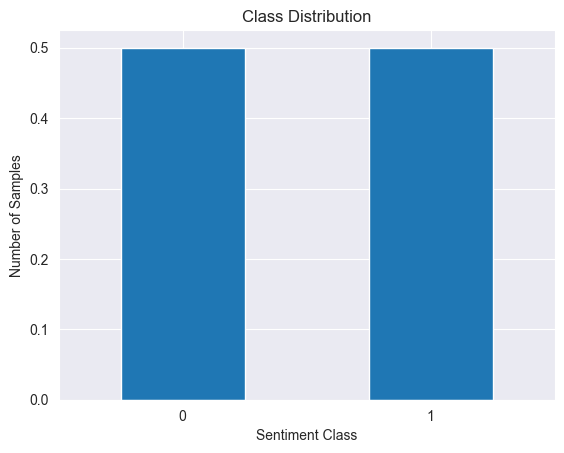

In [19]:
import matplotlib.pyplot as plt
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

In [20]:
target_list = list(df.columns)
target_list = target_list[1:]
target_list

['label']

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        self.targets = self.df['label'].astype(int).values
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index])

        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        target = torch.tensor(self.targets[index], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            #'token_type_ids': inputs["token_type_ids"].flatten(), -> nie potrzebne przy RoBERTa
            'targets': torch.tensor(self.targets[index], dtype=torch.long),
            'utterances': utterances
        }

In [22]:
# class BERTBinarySentimentClassificationClass(nn.Module):
#     def __init__(self, bert_model):
#         super(BERTBinarySentimentClassificationClass, self).__init__()
#         self.bert = bert_model
#         self.dropout = nn.Dropout(p=DROPOUT_RATE)
#         self.out = nn.Linear(self.bert.config.hidden_size, 1)  # Binary classification (1 output)
# 
#     def forward(self, input_ids, attention_mask, token_type_ids=None):
#         # Forward pass przez BERT
#         outputs = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids
#         )
#         pooled_output = outputs.pooler_output
#         dropout_output = self.dropout(pooled_output)
#         return self.out(dropout_output)
#         #return torch.sigmoid(self.out(dropout_output))

In [23]:
# class RoBERTaBinarySentimentClassificationClass(nn.Module):
#     def __init__(self, roberta_model):
#         super(RoBERTaBinarySentimentClassificationClass, self).__init__()
#         self.roberta = roberta_model
#         self.dropout = nn.Dropout(p=DROPOUT_RATE)
#         self.out = nn.Linear(self.roberta.config.hidden_size, 1)  # Binary classification
# 
#     def forward(self, input_ids, attention_mask):
#         # Forward pass przez RoBERTa
#         outputs = self.roberta(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )
#         # Sprawdzenie, czy pooler_output jest dostępne
#         if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
#             pooled_output = outputs.pooler_output  # Preferowane, jeśli dostępne
#         else:
#             pooled_output = outputs.last_hidden_state[:, 0, :]  # Wykorzystanie tokena [CLS]
# 
#         dropout_output = self.dropout(pooled_output)
#         return self.out(dropout_output)
#         # return torch.sigmoid(self.out(dropout_output))  # Jeśli używasz BCEWithLogitsLoss, sigmoid nie jest potrzebny

In [24]:
class BERTLSTMClassifier(nn.Module):
    def __init__(self, bert_model, lstm_hidden_dim=128, lstm_layers=1, dropout_rate=DROPOUT_RATE, bidirectional=True):
        super(BERTLSTMClassifier, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout_rate if lstm_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout_rate)
        # Jeśli LSTM jest dwukierunkowe, rozmiar wejścia do fc to lstm_hidden_dim*2, w przeciwnym wypadku lstm_hidden_dim
        fc_input_dim = lstm_hidden_dim * 2 if bidirectional else lstm_hidden_dim
        self.fc = nn.Linear(fc_input_dim, 1)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Pobranie reprezentacji z BERTa (cała sekwencja)
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        # last_hidden_state: tensor o wymiarach (batch_size, seq_length, hidden_size)
        sequence_output = bert_output.last_hidden_state

        # Przepuszczenie przez LSTM
        lstm_output, (hidden, _) = self.lstm(sequence_output)
        # Jeśli LSTM jest dwukierunkowe, ukryty stan z ostatniej warstwy ma wymiar (num_layers*2, batch, hidden_dim)
        if self.lstm.bidirectional:
            # Pobieramy ostatnie stany z obu kierunków i je łączymy
            hidden_forward = hidden[-2, :, :]  # ostatnia warstwa, kierunek "forward"
            hidden_backward = hidden[-1, :, :]  # ostatnia warstwa, kierunek "backward"
            hidden = torch.cat((hidden_forward, hidden_backward), dim=1)
        else:
            hidden = hidden[-1, :, :]

        dropout_output = self.dropout(hidden)
        logits = self.fc(dropout_output)
        return logits

In [25]:
# class BERTCNNClassifier(nn.Module):
#     def __init__(self, bert_model, num_filters=100, filter_sizes=[2, 3, 4], dropout_rate=0.3):
#         super(BERTCNNClassifier, self).__init__()
#         self.bert = bert_model
#         # Tworzymy listę konwolucji: każdy filtr działa na "okno" o danej wielkości
#         self.convs = nn.ModuleList([
#             nn.Conv2d(
#                 in_channels=1,
#                 out_channels=num_filters,
#                 kernel_size=(fs, self.bert.config.hidden_size)
#             )
#             for fs in filter_sizes
#         ])
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(num_filters * len(filter_sizes), 1)
# 
#     def forward(self, input_ids, attention_mask, token_type_ids=None):
#         bert_output = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids
#         )
#         # last_hidden_state: (batch_size, seq_length, hidden_size)
#         sequence_output = bert_output.last_hidden_state
# 
#         # Dodajemy wymiar kanału (potrzebny dla CNN)
#         x = sequence_output.unsqueeze(1)  # (batch_size, 1, seq_length, hidden_size)
# 
#         # Przepuszczamy przez każdy filtr konwolucyjny
#         conved = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
#         # conved[i] ma wymiary: (batch_size, num_filters, seq_length - filter_size + 1)
# 
#         # Wykonujemy max-pooling na każdej mapie cech
#         pooled = [F.max_pool1d(feature_map, kernel_size=feature_map.size(2)).squeeze(2) for feature_map in conved]
#         # pooled[i] ma wymiary: (batch_size, num_filters)
# 
#         # Łączymy wyniki z różnych filtrów
#         cat = torch.cat(pooled, dim=1)  # (batch_size, num_filters * len(filter_sizes))
# 
#         dropout_output = self.dropout(cat)
#         logits = self.fc(dropout_output)
#         return logits


In [26]:
def freeze_bert_layers(model, freeze_until_layer=6):
    """
    Zamraża wszystkie warstwy enkodera BERT, których numer jest mniejszy niż freeze_until_layer.
    W modelu BERT-base (12 warstw): przy freeze_until_layer=6, zamrożone zostaną warstwy 0-5.
    """
    for name, param in model.named_parameters():
        # Szukamy parametrów, które należą do warstw enkodera
        if "bert.encoder.layer" in name:
            # Nazwa ma postać: bert.encoder.layer.<layer_num>...
            try:
                layer_num = int(name.split('.')[3])
            except:
                continue  # zabezpieczenie, gdyby parsowanie się nie udało
            if layer_num < freeze_until_layer:
                param.requires_grad = False
                # Możesz też dodać print dla debugowania:
                print(f"Freezing parameter: {name}")
    print(f"Frozen BERT layers: 0-{freeze_until_layer - 1}")


In [27]:
#model_path = 'best_model_state.bin'
bert_model = BertModel.from_pretrained("bert-base-uncased")
#model = BERTBinarySentimentClassificationClass(bert_model)
model = BERTLSTMClassifier(bert_model, lstm_layers=LSTM_LAYERS, lstm_hidden_dim=LSTM_HIDDEN_DIM)
#model = BERTCNNClassifier(bert_model)

# roberta_model = RobertaModel.from_pretrained("roberta-base")
# model = RoBERTaBinarySentimentClassificationClass(roberta_model)


#model.load_state_dict(torch.load(model_path))
model.to(device)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


In [28]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN)

In [29]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

In [30]:
data = next(iter(train_data_loader))
outputs = model(data["input_ids"], attention_mask=data["attention_mask"])
print(outputs)

tensor([[-0.0478],
        [-0.0968],
        [-0.0622],
        [-0.0685],
        [-0.0900],
        [-0.0642],
        [-0.0509],
        [-0.0031],
        [-0.0046],
        [-0.0384],
        [-0.0328],
        [-0.0039],
        [-0.0450],
        [-0.0103],
        [-0.0476],
        [-0.0575],
        [-0.0457],
        [-0.0783],
        [-0.0325],
        [-0.0206],
        [-0.0268],
        [-0.0693],
        [-0.0808],
        [-0.0061],
        [-0.0521],
        [ 0.0226],
        [-0.0412],
        [ 0.0488],
        [-0.0052],
        [ 0.0282],
        [-0.0690],
        [-0.0591]], grad_fn=<AddmmBackward0>)


In [31]:
test_text = "We are testing BERT tokenizer."
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")

In [32]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(
    input_ids=encodings['input_ids'],
    attention_mask=encodings['attention_mask']
)

In [33]:
# def loss_fn(outputs, targets):
#     # jesli uzywamy BCEWithLogitsLoss, to w modelu nie musimy dodawać sigmoid, bo ta funkcja już zawiera operację sigmoid.
#     return torch.nn.BCEWithLogitsLoss()(outputs.squeeze(-1), targets.float())

# def loss_fn(outputs, targets):
#     return torch.nn.BCELoss()(outputs.squeeze(), targets.float())

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        # inputs powinny być wyjściem z modelu (logity)
        bce_loss = self.bce(inputs, targets.float())
        probas = torch.sigmoid(inputs)
        # Obliczenie p_t: dla próbki z target=1 mamy probas, dla target=0 mamy 1 - probas
        p_t = targets * probas + (1 - targets) * (1 - probas)
        loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

loss_fn = FocalLoss(alpha=FOCAL_LOSS_ALFA, gamma=FOCAL_LOSS_GAMMA, reduction='mean')
#gamma
#Odpowiada za redukowanie wagi łatwo sklasyfikowanych przykładów. Wyższa wartość gamma sprawia, że model skupia się bardziej na trudnych przypadkach.
#Jeśli gamma jest zbyt wysoka (np. 2 lub więcej), może to powodować, że model zaniedbuje uczenie się na przykładach, które są łatwiejsze do sklasyfikowania, co może negatywnie wpływać na ogólną stabilność treningu.
#W twoim przypadku, skoro klasa 1 nie jest przewidywana, warto spróbować obniżyć wartość gamma (np. do 1), aby nie tłumić gradientów zbyt mocno.

#alpha
#Umożliwia balansowanie klas poprzez przypisanie większej wagi przykładom z klasy, która jest niedoreprezentowana lub trudniejsza do nauki.
# W twoim kodzie alpha=1 oznacza, że wszystkie próbki są traktowane jednakowo. Jeśli obserwujesz, że jedna klasa (tu klasa 1) jest pomijana, możesz spróbować nadać jej większą wagę.
# Możesz rozważyć modyfikację alpha na wektor, np. alpha = [0.25, 0.75] lub inne wartości, w zależności od nierównowagi między klasami. To pozwoli nadać przykładom z klasy 1 większy wpływ na stratę.


#Zmodyfikuj implementację, aby alpha było wektorem wag (np. alpha = [waga_klasy0, waga_klasy1]), co pozwoli na precyzyjne balansowanie strat między klasami.
#Przeprowadź serię eksperymentów (np. grid search) z różnymi wartościami gamma i alpha, aby znaleźć najlepszą kombinację, która poprawi metryki takie jak F1-score, szczególnie dla klasy 1.


In [34]:
writer = SummaryWriter(log_dir='logs')

#optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# learning rate scheduler
# ReduceLROnPlateau może obniżać lr do bardzo małych wartości, co czasem prowadzi do problemów. Możesz dodać min_lr, aby ograniczyć ten efekt:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=MODE, patience=PATIENCE, factor=FACTOR, verbose=VERBOSE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

C:\Users\juwieczo\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
def train_model(training_loader, model, optimizer):
    """
    Trenuje model na danych treningowych i zwraca model, dokładność, średni loss oraz F1-score.

    Args:
        training_loader (DataLoader): DataLoader z danymi treningowymi.
        model (torch.nn.Module): Model do trenowania.
        optimizer (torch.optim.Optimizer): Optymalizator do aktualizacji wag modelu.
        loss_fn (callable): Funkcja strat, np. nn.BCEWithLogitsLoss.

    Returns:
        model (torch.nn.Module): Wytrenowany model.
        train_accuracy (float): Dokładność modelu na zbiorze treningowym.
        avg_loss (float): Średnia wartość funkcji strat.
        train_f1 (float): F1-score (binary) na zbiorze treningowym.
    """
    # Inicjalizacja zmiennych do śledzenia wyników
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.train()

    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)  # Binary targets jako float

        #outputs = model(ids, mask, token_type_ids if 'token_type_ids' in data else None)
        outputs = model(ids, mask if 'token_type_ids' in data else None)

        outputs = outputs.squeeze(-1)  # Dopasowanie wymiarów do binary classification (1D)

        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        preds = torch.sigmoid(outputs) >= 0.5  # Sigmoid + progowanie przy 0.5
        correct_predictions += torch.sum(preds == targets).item()
        num_samples += targets.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        loop.set_postfix(batch_loss=loss.item())

    train_f1 = f1_score(all_labels, all_preds, average='binary')

    return model, correct_predictions / num_samples, np.mean(losses), train_f1

In [1]:
def eval_model(validation_loader, model, epoch):
    """
    Ewaluacja modelu na danych walidacyjnych.

    Args:
        validation_loader (DataLoader): DataLoader z danymi walidacyjnymi.
        model (torch.nn.Module): Model do oceny.
        loss_fn (callable): Funkcja strat, np. nn.BCEWithLogitsLoss.
        epoch (int): Aktualny numer epoki do logowania w TensorBoard.

    Returns:
        val_accuracy (float): Dokładność modelu na zbiorze walidacyjnym.
        avg_loss (float): Średnia wartość funkcji strat na zbiorze walidacyjnym.
        val_f1 (float): F1-score (binary) na zbiorze walidacyjnym.
    """
    # Inicjalizacja zmiennych do śledzenia wyników
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    # Ustaw model w tryb ewaluacyjny
    model.eval()

    # Wyłącz gradienty dla ewaluacji
    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)  # Binary targets jako float

            #outputs = model(ids, mask, token_type_ids if 'token_type_ids' in data else None)
            outputs = model(ids, mask if 'token_type_ids' in data else None)

            outputs = outputs.squeeze(-1)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            preds = torch.sigmoid(outputs) >= 0.5  # Sigmoid + progowanie przy 0.5
            correct_predictions += torch.sum(preds == targets).item()
            num_samples += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = np.mean(losses)
    val_f1 = f1_score(all_labels, all_preds, average='binary')

    writer.add_scalar('Loss/validation', avg_loss, epoch)
    writer.add_scalar('F1-Score/validation', val_f1, epoch)

    return correct_predictions / num_samples, avg_loss, val_f1


In [37]:
def eval_model(validation_loader, model, epoch):
    """
    Ewaluacja modelu na danych walidacyjnych.

    Args:
        validation_loader (DataLoader): DataLoader z danymi walidacyjnymi.
        model (torch.nn.Module): Model do oceny.
        loss_fn (callable): Funkcja strat, np. nn.BCEWithLogitsLoss.
        epoch (int): Aktualny numer epoki do logowania w TensorBoard.

    Returns:
        val_accuracy (float): Dokładność modelu na zbiorze walidacyjnym.
        avg_loss (float): Średnia wartość funkcji strat na zbiorze walidacyjnym.
        val_f1 (float): F1-score (binary) na zbiorze walidacyjnym.
    """
    # Inicjalizacja zmiennych do śledzenia wyników
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    # Ustaw model w tryb ewaluacyjny
    model.eval()

    # Wyłącz gradienty dla ewaluacji
    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)  # Binary targets jako float

            #outputs = model(ids, mask, token_type_ids if 'token_type_ids' in data else None)
            outputs = model(ids, mask if 'token_type_ids' in data else None)

            outputs = outputs.squeeze(-1)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            preds = torch.sigmoid(outputs) >= 0.5  # Sigmoid + progowanie przy 0.5
            correct_predictions += torch.sum(preds == targets).item()
            num_samples += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = np.mean(losses)
    val_f1 = f1_score(all_labels, all_preds, average='binary')

    writer.add_scalar('Loss/validation', avg_loss, epoch)
    writer.add_scalar('F1-Score/validation', val_f1, epoch)

    return correct_predictions / num_samples, avg_loss, val_f1
def count_trainable_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [38]:
history = defaultdict(list)
best_f1 = 0
patience_counter = 0


for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss, train_f1 = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f} | Train F1 {train_f1:.4f}')

    val_acc, val_loss, val_f1 = eval_model(val_data_loader, model, epoch)
    print(f'Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f} | Val F1 {val_f1:.4f}')

    # Logowanie metryk do TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('F1-Score/train', train_f1, epoch)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    if val_f1 > best_f1:
        tokenizer.save_pretrained(output_dir)
        model.bert.save_pretrained(output_dir)
        torch.save(model.state_dict(), os.path.join(output_dir, "best_binary_model_state.bin"))
        #torch.save(model.state_dict(), "best_binary_model_state.bin")
        best_f1 = val_f1
        print("Saved new best model.")

    #scheduler.step(val_loss)  # Tuning LR
    scheduler.step()

writer.close()

Epoch 1/10


  0%|          | 0/41 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Train loss 0.6948 | Train accuracy 0.5050 | Train F1 0.4835
Val loss 0.6925 | Val accuracy 0.5520 | Val F1 0.6356
Saved new best model.
Epoch 2/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss 0.6914 | Train accuracy 0.5181 | Train F1 0.5293
Val loss 0.6931 | Val accuracy 0.5161 | Val F1 0.0000
Epoch 3/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss 0.6894 | Train accuracy 0.5404 | Train F1 0.5733
Val loss 0.6925 | Val accuracy 0.5305 | Val F1 0.5868
Epoch 4/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss 0.6722 | Train accuracy 0.5920 | Train F1 0.6051
Val loss 0.7061 | Val accuracy 0.5412 | Val F1 0.6559
Saved new best model.
Epoch 5/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss 0.6635 | Train accuracy 0.6135 | Train F1 0.6494
Val loss 0.6983 | Val accuracy 0.5090 | Val F1 0.5018
Epoch 6/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss 0.6485 | Train accuracy 0.6259 | Train F1 0.6173
Val loss 0.6908 | Val accuracy 0.5484 | Val F1 0.5909
Epoch 7/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss 0.6204 | Train accuracy 0.6774 | Train F1 0.7014
Val loss 0.6998 | Val accuracy 0.5663 | Val F1 0.6159
Epoch 8/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss 0.5975 | Train accuracy 0.7090 | Train F1 0.7183
Val loss 0.6967 | Val accuracy 0.5806 | Val F1 0.6113
Epoch 9/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss 0.5818 | Train accuracy 0.7413 | Train F1 0.7477
Val loss 0.6889 | Val accuracy 0.5878 | Val F1 0.6128
Epoch 10/10


  0%|          | 0/41 [00:00<?, ?it/s]

Train loss 0.5763 | Train accuracy 0.7352 | Train F1 0.7235
Val loss 0.6951 | Val accuracy 0.5771 | Val F1 0.6144


# Prediction on Adolescence

In [39]:
from torch.utils.data import Dataset, DataLoader
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False, # BERT-base-uncased zazwyczaj nie potrzebuje token_type_ids dla pojedynczych zdań
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [40]:
# Ścieżka do zapisanego modelu
saved_model_path = './fine_tuned_bert_lstm_model'
model_weights_path = os.path.join(saved_model_path, "best_binary_model_state.bin")

# Wczytaj tokenizer z folderu
print("Loading tokenizer from saved model path...")
tokenizer = BertTokenizer.from_pretrained(saved_model_path)

# Wczytaj bazowy model BERT z folderu (to zapewni zgodność słownika)
print("Loading pre-trained BERT model from saved model path...")
bert_model = BertModel.from_pretrained(saved_model_path)

# Zainicjuj Twój customowy klasyfikator
print("Initializing BERTLSTMClassifier...")
model = BERTLSTMClassifier(bert_model, lstm_layers=LSTM_LAYERS, lstm_hidden_dim=LSTM_HIDDEN_DIM)

Loading tokenizer from saved model path...
Loading pre-trained BERT model from saved model path...
Initializing BERTLSTMClassifier...


In [41]:
try:
    print(f"Loading model weights from {model_weights_path}...")
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    print("Model weights loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file '{model_weights_path}' not found. Please ensure the path and filename are correct.")
    exit()
except Exception as e:
    print(f"An error occurred during model loading: {e}")
    exit()

Loading model weights from ./fine_tuned_bert_lstm_model\best_binary_model_state.bin...


C:\Users\juwieczo\AppData\Local\Temp\ipykernel_30176\2232047830.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_

Model weights loaded successfully.


In [42]:
model.to(device)
model.eval()

BERTLSTMClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [43]:
print("Loading tokenizer...")
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Loading tokenizer...


In [44]:
print("Loading new dataset: adolescence_s01_e03_subtitles_eng.csv")
df_adolescence = pd.read_csv('C:/Users/juwieczo/DataspellProjects/meisd_project/data/adolescence_s01_e03_subtitles_eng.csv')

Loading new dataset: adolescence_s01_e03_subtitles_eng.csv


In [45]:
if 'text' not in df_adolescence.columns:
    print("Warning: 'text' column not found in df_adolescence. Assuming first column contains the text.")
    texts_for_inference = df_adolescence.iloc[:, 0].tolist()
else:
    texts_for_inference = df_adolescence['text'].tolist()

In [46]:
inference_dataset = InferenceDataset(
    texts=texts_for_inference,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

inference_data_loader = torch.utils.data.DataLoader(
    inference_dataset,
    batch_size=BATCH,
    shuffle=False,
    num_workers=0
)

In [47]:
print("Starting inference on the new dataset...")
predictions = []
original_texts = []

with torch.no_grad(): # Wyłączamy obliczanie gradientów dla przewidywań
    for data in tq.tqdm(inference_data_loader, total=len(inference_data_loader), desc="Predicting"):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        original_texts.extend(data['text'])

        # token_type_ids nie jest zwracane przez InferenceDataset, więc nie przekazujemy
        # outputs = model(input_ids, attention_mask, token_type_ids=None) # Jeśli model wymaga token_type_ids
        outputs = model(input_ids, attention_mask)

        # Logity są zwracane przez model, przekształć je na prawdopodobieństwa za pomocą sigmoid
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()

        # Próg 0.5 do binarnej klasyfikacji
        batch_predictions = (probs >= 0.5).astype(int)
        predictions.extend(batch_predictions)

print("Inference complete.")

Starting inference on the new dataset...


Predicting:   0%|          | 0/26 [00:00<?, ?it/s]

Inference complete.


In [48]:
results_df = pd.DataFrame({
    'text': original_texts,
    'predicted_label': predictions
})

output_filename = 'adolescence_s01_e03_subtitles_predictions.csv'
results_df.to_csv(output_filename, index=False)

print(f"Predictions saved to {output_filename}")
print("\nSample predictions:")
print(results_df)

Predictions saved to adolescence_s01_e03_subtitles_predictions.csv

Sample predictions:
                                                text  predicted_label
0                                                Oh.                0
1                                  Do you work here?                1
2                      - Um, I'm a visitor. - Right.                0
3  Right. Do you wanna just come through for a se...                1
4                             Sorry. I'm a bit late.                0


# Transfer learning to ESConv dataset

In [49]:
def load_data(file_path):
    with open(file_path, "r", encoding='utf-8') as file:
        data = json.load(file)
    return data

#dataset = load_data("D:/julixus/MEISD/meisd_project/data/ESConv.json")
dataset = load_data("C:/Users/juwieczo/DataspellProjects/meisd_project/data/ESConv.json")

In [50]:
def extract_seeker_data(data, key):
    result = []

    for entry in data:
        dialog = entry['dialog']
        seeker_dialog = [item['content'].strip() for item in dialog if item['speaker'] == 'seeker']

        quarter_length = max(1, len(seeker_dialog) // 4)

        if key == 'initial_emotion_intensity':
            selected_dialog = seeker_dialog[:quarter_length]
        elif key == 'final_emotion_intensity':
            selected_dialog = seeker_dialog[-quarter_length:]
        else:
            continue

        result.append({
            key: entry['survey_score']['seeker'][key],
            'dialog': selected_dialog
        })

    return result

first_25_percent = extract_seeker_data(dataset, 'initial_emotion_intensity')
#last_25_percent = extract_seeker_data(dataset, 'final_emotion_intensity')

first_25_df = pd.DataFrame(first_25_percent)
#last_25_df = pd.DataFrame(last_25_percent)

first_25_df.head()

,initial_emotion_intensity,dialog
0,5,"[Hello, I am having a lot of anxiety about qui..."
1,5,"[hello im looking for someone to talk to, im f..."
2,4,"[Hello, I'm concerned about my job. I have bee..."
3,4,"[I am dong good. You?, I have been staying hom..."
4,5,"[Infinitely complicated., Too many decisions. ..."


In [51]:
label_counts = first_25_df['initial_emotion_intensity'].value_counts()
least_common_label = label_counts.idxmin()
first_25_df = first_25_df[first_25_df['initial_emotion_intensity'] != least_common_label]
first_25_df['initial_emotion_intensity'] = pd.to_numeric(first_25_df['initial_emotion_intensity'], errors='coerce')
first_25_df['initial_emotion_intensity'] = first_25_df['initial_emotion_intensity'] - 2

In [52]:
first_25_df.rename(columns={
    'dialog': 'Utterances',
    'initial_emotion_intensity': 'label'
})

,label,Utterances
0,3,"[Hello, I am having a lot of anxiety about qui..."
1,3,"[hello im looking for someone to talk to, im f..."
2,2,"[Hello, I'm concerned about my job. I have bee..."
3,2,"[I am dong good. You?, I have been staying hom..."
4,3,"[Infinitely complicated., Too many decisions. ..."
...,...,...
1295,3,"[I feel sleepy but can not sleep, It has alway..."
1296,2,"[I am fine. thanks. how about you ?, I lost my..."
1297,1,"[HI how are you today, Doing well, thanks.]"
1298,1,"[Hello, I am a little down today. How are you..."


In [53]:
df_data['label'] = (df_data['max_intensity'] == 2).astype(int)
columns = ['Utterances', 'label']
df = df_data[columns].copy()

In [54]:
df_train_esconv, df_temp_esconv = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
df_valid_esconv, df_test_esconv = train_test_split(df_temp_esconv, random_state=88, test_size=0.50, shuffle=True)
print(f"ESConv: Train {df_train_esconv.shape}, Valid {df_valid_esconv.shape}, Test {df_test_esconv.shape}")

ESConv: Train (759, 2), Valid (163, 2), Test (163, 2)


In [55]:
train_dataset_esconv = CustomDataset(df_train_esconv, tokenizer, MAX_LEN)
valid_dataset_esconv = CustomDataset(df_valid_esconv, tokenizer, MAX_LEN)
train_data_loader_esconv = torch.utils.data.DataLoader(train_dataset_esconv, batch_size=BATCH, shuffle=True)
valid_data_loader_esconv = torch.utils.data.DataLoader(valid_dataset_esconv, batch_size=BATCH, shuffle=False)

In [56]:
model.load_state_dict(torch.load("best_binary_model_state.bin"))
model.to(device)

C:\Users\juwieczo\AppData\Local\Temp\ipykernel_30176\2044755011.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_binary_model_state

BERTLSTMClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [57]:
total_params, trainable_params = count_trainable_parameters(model)
print(f"Before freezing on ESConv: Total params: {total_params}, Trainable params: {trainable_params}")

Before freezing on ESConv: Total params: 110797313, Trainable params: 110797313


In [58]:
freeze_bert_layers(model, freeze_until_layer=6)
total_params, trainable_params = count_trainable_parameters(model)
print(f"After freezing on ESConv: Total params: {total_params}, Trainable params: {trainable_params}")

Freezing parameter: bert.encoder.layer.0.attention.self.query.weight
Freezing parameter: bert.encoder.layer.0.attention.self.query.bias
Freezing parameter: bert.encoder.layer.0.attention.self.key.weight
Freezing parameter: bert.encoder.layer.0.attention.self.key.bias
Freezing parameter: bert.encoder.layer.0.attention.self.value.weight
Freezing parameter: bert.encoder.layer.0.attention.self.value.bias
Freezing parameter: bert.encoder.layer.0.attention.output.dense.weight
Freezing parameter: bert.encoder.layer.0.attention.output.dense.bias
Freezing parameter: bert.encoder.layer.0.attention.output.LayerNorm.weight
Freezing parameter: bert.encoder.layer.0.attention.output.LayerNorm.bias
Freezing parameter: bert.encoder.layer.0.intermediate.dense.weight
Freezing parameter: bert.encoder.layer.0.intermediate.dense.bias
Freezing parameter: bert.encoder.layer.0.output.dense.weight
Freezing parameter: bert.encoder.layer.0.output.dense.bias
Freezing parameter: bert.encoder.layer.0.output.LayerNor

In [59]:
optimizer_esconv = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE_FINE, weight_decay=WEIGHT_DECAY)
scheduler_esconv = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_esconv, T_max=EPOCHS)

C:\Users\juwieczo\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [60]:
history_esconv = defaultdict(list)
best_f1_esconv = 0

print("Fine-tuning on ESConv...")
for epoch in range(1, EPOCHS + 1):
    print(f'Fine-tuning Epoch {epoch}/{EPOCHS} (ESConv)')
    model, train_acc, train_loss, train_f1 = train_model(train_data_loader_esconv, model, optimizer_esconv)
    print(f'ESConv Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f} | Train F1 {train_f1:.4f}')
    val_acc, val_loss, val_f1 = eval_model(valid_data_loader_esconv, model, epoch)
    print(f'ESConv Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f} | Val F1 {val_f1:.4f}')
    history_esconv['train_acc'].append(train_acc)
    history_esconv['train_loss'].append(train_loss)
    history_esconv['train_f1'].append(train_f1)
    history_esconv['val_acc'].append(val_acc)
    history_esconv['val_loss'].append(val_loss)
    history_esconv['val_f1'].append(val_f1)
    if val_f1 > best_f1_esconv:
        torch.save(model.state_dict(), "best_fine_tuned_model_state.bin")
        best_f1_esconv = val_f1
        print("Saved new best ESConv model.")
    scheduler_esconv.step()
print("Fine-tuning on ESConv complete!")
# Zamknij TensorBoard writer
writer.close()

Fine-tuning on ESConv...
Fine-tuning Epoch 1/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6884 | Train accuracy 0.5441 | Train F1 0.6239
ESConv Val loss 0.6855 | Val accuracy 0.5890 | Val F1 0.6215
Saved new best ESConv model.
Fine-tuning Epoch 2/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6879 | Train accuracy 0.5468 | Train F1 0.5567
ESConv Val loss 0.6823 | Val accuracy 0.5890 | Val F1 0.6378
Saved new best ESConv model.
Fine-tuning Epoch 3/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6834 | Train accuracy 0.5586 | Train F1 0.5315
ESConv Val loss 0.6788 | Val accuracy 0.6074 | Val F1 0.6559
Saved new best ESConv model.
Fine-tuning Epoch 4/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6779 | Train accuracy 0.5929 | Train F1 0.6161
ESConv Val loss 0.6756 | Val accuracy 0.5890 | Val F1 0.6633
Saved new best ESConv model.
Fine-tuning Epoch 5/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6746 | Train accuracy 0.5982 | Train F1 0.6408
ESConv Val loss 0.6726 | Val accuracy 0.5828 | Val F1 0.6566
Fine-tuning Epoch 6/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6738 | Train accuracy 0.5916 | Train F1 0.6220
ESConv Val loss 0.6706 | Val accuracy 0.5706 | Val F1 0.6429
Fine-tuning Epoch 7/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6746 | Train accuracy 0.5797 | Train F1 0.6057
ESConv Val loss 0.6689 | Val accuracy 0.5583 | Val F1 0.6289
Fine-tuning Epoch 8/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6708 | Train accuracy 0.6047 | Train F1 0.6394
ESConv Val loss 0.6691 | Val accuracy 0.5828 | Val F1 0.6566
Fine-tuning Epoch 9/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6691 | Train accuracy 0.5863 | Train F1 0.6323
ESConv Val loss 0.6684 | Val accuracy 0.5767 | Val F1 0.6497
Fine-tuning Epoch 10/10 (ESConv)


  0%|          | 0/24 [00:00<?, ?it/s]

ESConv Train loss 0.6705 | Train accuracy 0.6008 | Train F1 0.6406
ESConv Val loss 0.6683 | Val accuracy 0.5767 | Val F1 0.6497
Fine-tuning on ESConv complete!


In [62]:
test_dataset_esconv = CustomDataset(df_test_esconv, tokenizer, MAX_LEN)
test_data_loader_esconv = torch.utils.data.DataLoader(test_dataset_esconv, batch_size=BATCH, shuffle=False)
predictions, true_labels = [], []
model.eval()
with torch.no_grad():
    for batch in test_data_loader_esconv:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['targets'].to(device)
        outputs = model(input_ids, attention_mask)
        outputs = outputs.squeeze(-1)
        preds = torch.sigmoid(outputs) >= 0.5
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("ESConv Test Set Report:")
print(classification_report(true_labels, predictions))


ESConv Test Set Report:
              precision    recall  f1-score   support

           0       0.75      0.03      0.06        89
           1       0.46      0.99      0.63        74

    accuracy                           0.47       163
   macro avg       0.60      0.51      0.35       163
weighted avg       0.62      0.47      0.32       163


In [ ]:
def test_model(data_loader, model):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            #outputs = model(input_ids=input_ids)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Run validation
predictions, true_labels = test_model(val_data_loader, model)

# Calculate metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))